Problem Statement:

Given a univariate time series data of number of vehicles each hour in four different junctions, forecast

1) the next day's number of vehicles in each junction (single-step forecasting),

2) the next several days' number of vehicles in each junction (repeated single-step forecasting)

using deep learning approach (LSTM).

Predictions are evaluated with Root Mean Squared Errors(RMSE).

Outline

Pre-processing

Modeling with LSTM

Results

IMPORTING THE DATASET

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

PRE-PROCESSING:

In [ ]:
!pip install torchinfo
!pip install statsmodels

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split


import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import scipy.stats as scs
from statsmodels.graphics.api import qqplot

from itertools import product
from tqdm.notebook import tqdm

In [ ]:
# load the dataset
traffic_df = pd.read_csv('/content/traffic.csv')

In [ ]:
# inspect the dataset
traffic_df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1.0,15.0,2.015110e+10
1,2015-11-01 01:00:00,1.0,13.0,2.015110e+10
2,2015-11-01 02:00:00,1.0,10.0,2.015110e+10
3,2015-11-01 03:00:00,1.0,7.0,2.015110e+10
4,2015-11-01 04:00:00,1.0,9.0,2.015110e+10


In [ ]:
traffic_df.shape

(28446, 4)

In [ ]:
# check data types
traffic_df.dtypes


,0
DateTime,object
Junction,float64
Vehicles,float64
ID,float64


In [ ]:
# convert to datetime type
traffic_df['DateTime'] = pd.to_datetime(traffic_df['DateTime'])

# set datetime to index
traffic_df.set_index('DateTime',inplace=True)

In [ ]:
# check for null values
traffic_df.isnull().sum()

,0
Junction,1
Vehicles,1
ID,1


Let us first analyse at junction 1

In [ ]:
junc1 = traffic_df[traffic_df['Junction']==1]

In [ ]:
junc1.head()

,Junction,Vehicles,ID
DateTime,,,
2015-11-01 00:00:00,1.0,15.0,2.015110e+10
2015-11-01 01:00:00,1.0,13.0,2.015110e+10
2015-11-01 02:00:00,1.0,10.0,2.015110e+10
2015-11-01 03:00:00,1.0,7.0,2.015110e+10
2015-11-01 04:00:00,1.0,9.0,2.015110e+10


In [ ]:
junc1.shape

(14592, 3)

<Axes: xlabel='DateTime'>

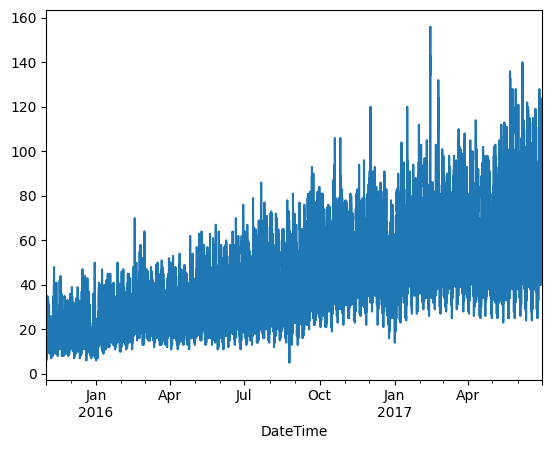

In [ ]:
junc1['Vehicles'].plot()

In [ ]:
# resample the data as daily average
daily_junc1 = junc1.Vehicles.resample('D').mean()

In [ ]:
daily_junc1

,Vehicles
DateTime,
2015-11-01,13.625000
2015-11-02,22.750000
2015-11-03,22.666667
2015-11-04,20.750000
2015-11-05,19.333333
...,...
2017-06-26,73.916667
2017-06-27,91.125000
2017-06-28,86.666667


In [ ]:
daily_junc1.shape

(608,)

<Axes: xlabel='DateTime'>

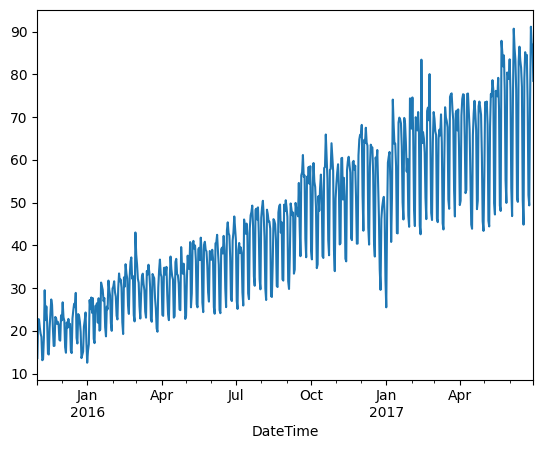

In [ ]:
daily_junc1.plot()

<Axes: >

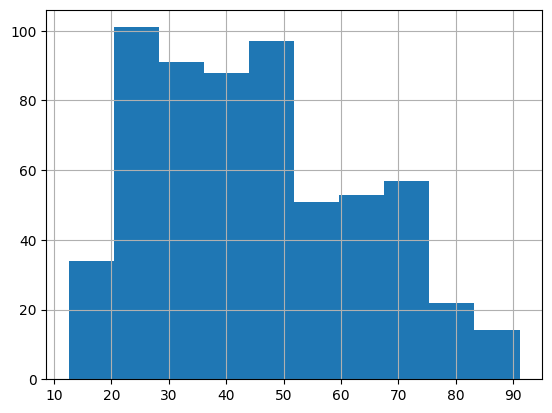

In [ ]:
# check the data distribution
daily_junc1.hist()

In [ ]:
# Defining a function that creates sequences and targets
def generate_sequences(ts: pd.Series, tw: int, pw: int):
    '''
    df: Pandas Series of the univariate time-series
    tw: Training Window - Integer defining how many steps to look back
    pw: Prediction Window - Integer defining how many steps forward to predict

    returns: dictionary of sequences and targets for all sequences
    '''
    data = dict() # Store results into a dictionary
    L = len(ts)
    for i in range(L-tw):
        # Get current sequence
        sequence = ts[i:i+tw].values
        sequence = np.reshape(sequence, (len(sequence),-1))
        # Get values right after the current sequence
        target = ts[i+tw:i+tw+pw].values
        target = np.reshape(target, (len(target),-1))
        data[i] = {'sequence': sequence, 'target': target}
    return data

In [ ]:
class SequenceDataset(Dataset):

    def __init__(self, df):
        self.data = df

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])

    def __len__(self):
        return len(self.data)

In [ ]:
# we are using 7 sequences to predict the next 1 value
lookback = 7 #training window
n_pred = 1 #prediction window

In [ ]:
sequences = generate_sequences(daily_junc1, lookback, n_pred)

In [ ]:
len(sequences) # sanity check, should be len(data) - lookback = 608 - 7

601

In [ ]:
dataset = SequenceDataset(sequences)

In [ ]:
split = 0.67 # Train/Test Split ratio

In [ ]:
train_len = int(len(dataset)*split)
lens = [train_len, len(dataset)-train_len]

In [ ]:

lens

[402, 199]

In [ ]:
# random split of dataset into train and test set
r_train_ds, r_test_ds = random_split(dataset, lens)

In [ ]:
# sequential split of dataset into train and test set
s_train_ds = Subset(dataset, range(lens[0]))
s_test_ds = Subset(dataset, range(lens[0],lens[0]+lens[1]))

In [ ]:
BATCH_SIZE = 8 # Training batch size

In [ ]:
# create dataloaders
r_trainloader = DataLoader(r_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
r_testloader = DataLoader(r_test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
# create dataloaders
s_trainloader = DataLoader(s_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
s_testloader = DataLoader(s_test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
# reshape the data to be used as an input for LSTM
daily_junc1_ts = daily_junc1.values.astype('float32')
daily_junc1_ts = np.reshape(daily_junc1_ts, (len(daily_junc1_ts),-1))

LSTM MODEL:

In [ ]:
import torch
import torch.nn as nn

class SimpleLSTM(nn.Module):
    def __init__(self, output_size, input_size, hidden_size, num_layers, seq_length, dropout=0.2):
        super(SimpleLSTM, self).__init__()
        self.output_size = output_size
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                           num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc_1 = nn.Linear(hidden_size, 32)
        self.fc = nn.Linear(32, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        device = x.device
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        out = self.relu(output[:, -1, :])
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out.unsqueeze(1)


Training without optimization on random split...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 0: train MSE 2348.6531
Epoch 1: train MSE 2039.7544
Epoch 2: train MSE 1539.0205
Epoch 3: train MSE 1033.6595
Epoch 4: train MSE 655.3392
Epoch 5: train MSE 442.3236
Epoch 6: train MSE 326.6027
Epoch 7: train MSE 207.8471
Epoch 8: train MSE 140.5612
Epoch 9: train MSE 103.8566
Epoch 10: train MSE 86.4210
Epoch 11: train MSE 67.0266
Epoch 12: train MSE 57.2922
Epoch 13: train MSE 48.3979
Epoch 14: train MSE 45.8606
Epoch 15: train MSE 37.4475
Epoch 16: train MSE 35.3055
Epoch 17: train MSE 30.2345
Epoch 18: train MSE 31.8310
Epoch 19: train MSE 29.0490
Epoch 20: train MSE 28.4572
Epoch 21: train MSE 28.4996
Epoch 22: train MSE 24.9483
Epoch 23: train MSE 24.3081
Epoch 24: train MSE 23.7010
Epoch 25: train MSE 22.2587
Epoch 26: train MSE 25.4633
Epoch 27: train MSE 23.3242
Epoch 28: train MSE 21.1365
Epoch 29: train MSE 21.0184
Epoch 30: train MSE 23.4049
Epoch 31: train MSE 20.7890
Epoch 32: train MSE 19.8263
Epoch 33: train MSE 22.9629
Epoch 34: train MSE 22.3574
Epoch 35: train 

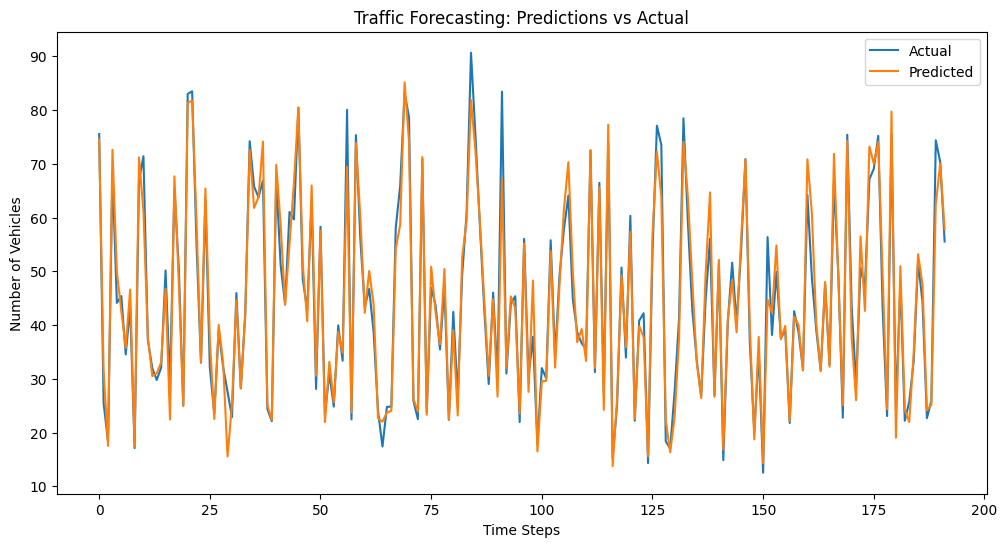

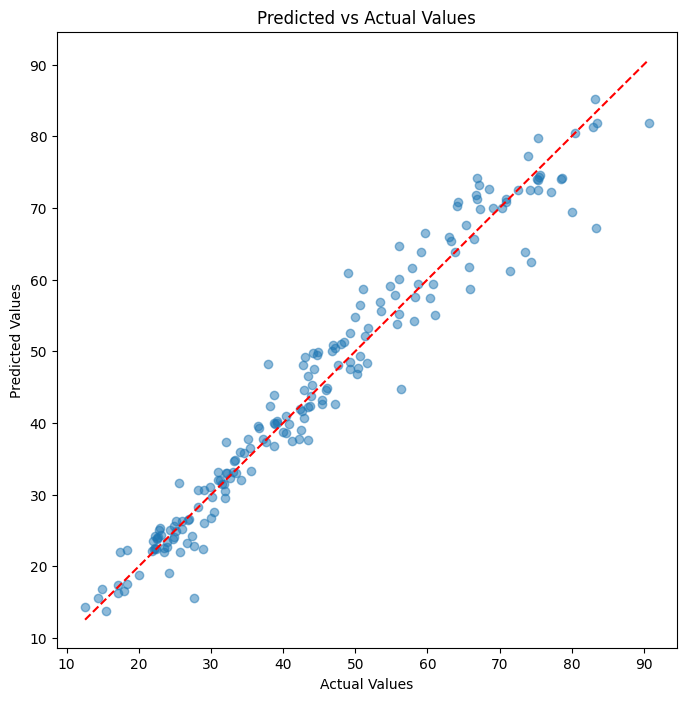

In [ ]:
# Define the LSTM model training function without optimization
def train_lstm_without_optimization(train_loader, test_loader, input_size, output_size, seq_length):
    hidden_size = 64
    num_layers = 1
    learning_rate = 0.01
    dropout = 0.2

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the model, optimizer, and loss function
    model = SimpleLSTM(output_size, input_size, hidden_size, num_layers, seq_length, dropout).to(device)
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()

    num_epochs = 100
    train_losses = []
    model.to(device)

    # Training loop
    for epoch in range(num_epochs):
        train_loss = 0.0
        model.train()

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to device

            optimizer.zero_grad()

            y_pred = model(X_batch)  # Now both model and input are on the same device
            loss = loss_fn(y_pred, y_batch)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

        epoch_loss = train_loss / len(train_loader)
        train_losses.append(epoch_loss)

        print("Epoch %d: train MSE %.4f" % (epoch, epoch_loss))

    # Return the trained model and losses
    return model, train_losses


import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    criterion = nn.MSELoss()
    test_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()

            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())

    test_mse = test_loss / len(test_loader)
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test RMSE: {np.sqrt(test_mse):.4f}")

    # Convert to numpy arrays for plotting
    all_predictions = np.array(all_predictions).reshape(-1)
    all_targets = np.array(all_targets).reshape(-1)

    # Plot predictions vs actual
    plt.figure(figsize=(12, 6))
    plt.plot(all_targets, label='Actual')
    plt.plot(all_predictions, label='Predicted')
    plt.title('Traffic Forecasting: Predictions vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Vehicles')
    plt.legend()
    plt.show()

    # Plot scatter of predicted vs actual
    plt.figure(figsize=(8, 8))
    plt.scatter(all_targets, all_predictions, alpha=0.5)
    plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], 'r--')
    plt.title('Predicted vs Actual Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

    return test_mse, all_predictions, all_targets


# Train without optimization
print("Training without optimization on random split...")
model_without_opt, train_losses_random = train_lstm_without_optimization(r_trainloader, r_testloader, 1, 1, lookback)

# Test the model after training
print("\n--- Testing Model Trained on Random Split ---")
r_test_mse, r_predictions, r_targets = test_model(model_without_opt, r_testloader)


In [ ]:

pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 6.1 MB/s eta 0:00:00


In [ ]:
# Complete GA code
from deap import base, creator, tools, algorithms
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Reset DEAP creator to avoid conflicts
if 'FitnessMin' in creator.__dict__:
    del creator.FitnessMin
    del creator.Individual

# Define the Genetic Algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimizing the MSE
creator.create("Individual", list, fitness=creator.FitnessMin)

# Define the genetic algorithm parameters
def create_individual():
    hidden_size = random.choice([32, 64, 96, 128, 160, 192, 224, 256])
    num_layers = random.choice([1, 2, 3])
    learning_rate = random.uniform(0.0001, 0.01)
    dropout = random.uniform(0.0, 0.5)
    return [hidden_size, num_layers, learning_rate, dropout]

# Define the evaluation function
def evaluate_ga(individual):
    hidden_size, num_layers, learning_rate, dropout = individual
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the model with current parameters
    model = SimpleLSTM(output_size=1, input_size=1, hidden_size=hidden_size,
                      num_layers=num_layers, seq_length=lookback, dropout=dropout).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Train for a few epochs
    for epoch in range(20):
        model.train()
        for X_batch, y_batch in r_trainloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluate on validation set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in r_testloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(r_testloader)
    return avg_val_loss,

# Create the toolbox
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Define repair function
def repair(individual):
    allowed_sizes = [32, 64, 96, 128, 160, 192, 224, 256]
    individual[0] = min(allowed_sizes, key=lambda x: abs(x - individual[0]))  # hidden_size
    individual[1] = int(min(max(round(individual[1]), 1), 3))  # num_layers
    individual[2] = float(min(max(individual[2], 0.0001), 0.01))  # learning_rate
    individual[3] = float(min(max(individual[3], 0.0), 0.5))  # dropout
    return individual

# Enhanced mutation with adaptive rates
def custom_mutate(individual):
    # Different mutation rates for different parameters
    if random.random() < 0.3:  # 30% chance to mutate hidden_size
        individual[0] += random.choice([-32, 0, 32])

    if random.random() < 0.2:  # 20% chance to mutate num_layers
        individual[1] += random.choice([-1, 0, 1])

    if random.random() < 0.4:  # 40% chance to mutate learning_rate
        individual[2] *= random.uniform(0.5, 1.5)

    if random.random() < 0.3:  # 30% chance to mutate dropout
        individual[3] += random.uniform(-0.1, 0.1)

    return repair(individual),

# Enhanced crossover operation
def custom_crossover(ind1, ind2):
    # Single point crossover with probability adjustment
    if random.random() < 0.5:
        # Standard crossover
        tools.cxOnePoint(ind1, ind2)
    else:
        # Arithmetic crossover for numerical parameters
        alpha = random.random()
        for i in range(len(ind1)):
            ind1[i], ind2[i] = alpha * ind1[i] + (1 - alpha) * ind2[i], alpha * ind2[i] + (1 - alpha) * ind1[i]

    ind1 = repair(ind1)
    ind2 = repair(ind2)
    return ind1, ind2

toolbox.register("mate", custom_crossover)
toolbox.register("mutate", custom_mutate)
toolbox.register("select", tools.selTournament, tournsize=5)
toolbox.register("evaluate", evaluate_ga)

# Run the genetic algorithm
def run_ga_optimization():
    random.seed(42)  # For reproducibility

    # Create a larger initial population
    population = toolbox.population(n=30)

    # Statistics setup
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)
    stats.register("std", np.std)

    # Hall of Fame to keep track of best individuals
    hof = tools.HallOfFame(5)

    # Run the genetic algorithm with more generations
    ngen = 20  # Increased number of generations
    cxpb = 0.7  # Crossover probability
    mutpb = 0.3  # Mutation probability (increased)

    # Run the algorithm with elitism
    algorithms.eaSimple(population, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=ngen,
                        stats=stats, halloffame=hof, verbose=True)

    # Get the best solution found
    best_individual = hof[0]
    print(f"Best individual: {best_individual}")
    print(f"Fitness: {best_individual.fitness.values[0]}")

    return best_individual

# Run GA optimization
best_params_ga = run_ga_optimization()

# Train final model with the best GA parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model_ga = SimpleLSTM(
    output_size=1,
    input_size=1,
    hidden_size=best_params_ga[0],
    num_layers=best_params_ga[1],
    seq_length=lookback,
    dropout=best_params_ga[3]
).to(device)

optimizer = optim.Adam(best_model_ga.parameters(), lr=best_params_ga[2], weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
loss_fn = nn.MSELoss()

# Training loop with early stopping
best_val_loss = float('inf')
patience = 20
counter = 0
train_losses = []
val_losses = []

for epoch in range(200):  # More epochs for final training
    # Training phase
    total_loss = 0
    best_model_ga.train()
    for X_batch, y_batch in r_trainloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = best_model_ga(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(best_model_ga.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()

    epoch_loss = total_loss / len(r_trainloader)
    train_losses.append(epoch_loss)

    # Validation phase
    best_model_ga.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in r_testloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = best_model_ga(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(r_testloader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/200], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save best model
        torch.save(best_model_ga.state_dict(), 'best_ga_model.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load the best model for evaluation
best_model_ga.load_state_dict(torch.load('best_ga_model.pth'))

# Evaluate the model after GA optimization
best_model_ga.eval()
test_loss_ga = 0
with torch.no_grad():
    for X_batch, y_batch in r_testloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = best_model_ga(X_batch)
        loss = loss_fn(outputs, y_batch)
        test_loss_ga += loss.item()

avg_test_loss_ga = test_loss_ga / len(r_testloader)
print(f"Test Loss after GA optimization: {avg_test_loss_ga:.4f}")
print(f"Test RMSE after GA optimization: {np.sqrt(avg_test_loss_ga):.4f}")


gen	nevals	avg    	min    	max    	std    
0  	30    	181.951	27.5753	356.992	152.353


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.34024060674816353 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.37543889979580486 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.03791677944578181 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers gr

1  	24    	82.2783	18.9629	337.507	88.7238


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2866833867578576 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4237471831737299 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4131094621348018 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers great

2  	25    	41.39  	20.252 	92.3039	21.4557


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.21925649116160575 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.24553422071059428 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.11809216166876471 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers gr

3  	23    	36.2961	18.7797	337.105	56.2091


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10408814516474948 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12028819428879384 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10119099946038129 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers gr

4  	25    	25.373 	19.2431	37.396 	4.35116


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.14515274464332417 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.31020779916458946 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.0949622096902983 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers gre

5  	21    	25.5965	17.9656	42.269 	7.0405 


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.23903104291606841 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2499474490123309 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17613317862233177 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers gre

6  	23    	35.6391	18.2966	339.744	56.7591


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.230458081757978 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.22390306600430498 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10484854667158378 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers grea

7  	23    	26.0801	19.011 	52.3078	7.82649


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.24485201180595348 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.24465136823158604 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2399292924846525 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers gre

8  	24    	47.3965	18.3074	342.209	77.9834


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2454852897876364 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.24349320214076292 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.19508416931016748 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers gre

9  	23    	23.4967	17.5851	48.8129	5.93279


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2413462753172549 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.20421660974745603 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1999686524382145 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers grea

10 	22    	23.3067	17.6734	59.0941	7.40335


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17048256183785737 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.16924384481818439 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.19388946252196398 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers gr

11 	23    	23.2109	18.6409	38.0534	4.61322


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.20157018786198033 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18980821779924645 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17387343630641006 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers gr

12 	23    	24.0481	18.6409	58.9978	7.73271


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.11822243273556642 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.15519680101680805 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.15993225402517464 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers gr

13 	23    	33.0979	18.2643	335.901	56.3903


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.16637842522684876 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.15690107364229475 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10787972705446369 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers gr

14 	23    	32.6339	18.2643	334.819	56.2805


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.15330585197774305 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.16001845476013932 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.030946455795420283 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers g

15 	26    	22.632 	16.9401	40.3834	4.66151


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.14799597206524367 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.15369031827798646 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18785860778500468 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers gr

16 	28    	22.951 	16.996 	34.8933	4.33316


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.14779197569312655 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1506835592857953 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12046178364066484 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers gre

17 	22    	21.6497	17.8015	32.2303	3.7022 


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1560528348445261 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1486402144908952 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.15426069223781683 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers grea

18 	20    	24.3137	17.3589	96.1756	13.8699


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10823410724266648 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.14440641512204386 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.11746782719107512 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers gr

19 	24    	22.8984	16.9628	47.3614	7.32278


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.04685912480966189 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1493999956439814 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.15006438780301745 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers gre

20 	26    	23.0198	17.8015	50.1386	6.19658
Best individual: [192, 1, 0.001942286657874504, 0.15690107364229475]
Fitness: 16.9400833149751
Epoch [10/200], Train Loss: 32.9397, Val Loss: 27.7636
Epoch [20/200], Train Loss: 25.1878, Val Loss: 20.1769
Epoch [30/200], Train Loss: 28.7861, Val Loss: 22.4674
Epoch [40/200], Train Loss: 24.8897, Val Loss: 28.2693
Epoch [50/200], Train Loss: 20.1389, Val Loss: 17.7384
Epoch [60/200], Train Loss: 18.6143, Val Loss: 15.9056
Epoch [70/200], Train Loss: 17.2357, Val Loss: 16.1360
Epoch [80/200], Train Loss: 18.5743, Val Loss: 17.9833
Early stopping at epoch 83
Test Loss after GA optimization: 15.7666
Test RMSE after GA optimization: 3.9707


In [ ]:
from hyperopt import fmin, tpe, hp, Trials
import torch.optim as optim

# Hyperparameter space for Bayesian Optimization
space = {
    'hidden_size': hp.choice('hidden_size', [32, 64, 128, 256]),
    'num_layers': hp.choice('num_layers', [1, 2, 3]),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
    'dropout': hp.uniform('dropout', 0.1, 0.3)
}

# Bayesian Optimization objective function
def objective(params):
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    learning_rate = params['learning_rate']
    dropout = params['dropout']

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleLSTM(output_size=1, input_size=1, hidden_size=hidden_size,
                      num_layers=num_layers, seq_length=lookback, dropout=dropout).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Training loop
    num_epochs = 10
    total_loss = 0

    for epoch in range(num_epochs):
        model.train()
        for data, target in r_trainloader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    avg_loss = total_loss / (len(r_trainloader) * num_epochs)

    # Evaluate the model
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in r_testloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_fn(output, target)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(r_testloader)
    return avg_test_loss

# Run Hyperopt for Bayesian Optimization
trials = Trials()
best_params_bo = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=10,
    trials=trials
)

# Convert the best parameters to their actual values
best_params_bo_dict = {
    'hidden_size': [32, 64, 128, 256][best_params_bo['hidden_size']],
    'num_layers': [1, 2, 3][best_params_bo['num_layers']],
    'learning_rate': best_params_bo['learning_rate'],
    'dropout': best_params_bo['dropout']
}

print("Best parameters found by Bayesian Optimization:")
for param, value in best_params_bo_dict.items():
    print(f"{param}: {value}")

# Train the model with the optimized parameters from BO
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bo_optimized = SimpleLSTM(
    output_size=1,
    input_size=1,
    hidden_size=best_params_bo_dict['hidden_size'],
    num_layers=best_params_bo_dict['num_layers'],
    seq_length=lookback,
    dropout=best_params_bo_dict['dropout']
).to(device)

optimizer = optim.Adam(model_bo_optimized.parameters(), lr=best_params_bo_dict['learning_rate'])
loss_fn = nn.MSELoss()

# Training loop for BO optimized model
for epoch in range(100):
    total_loss = 0
    model_bo_optimized.train()

    for data, target in r_trainloader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model_bo_optimized(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(r_trainloader)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/100, Training Loss: {avg_loss:.4f}")

# Evaluate the model after BO optimization
model_bo_optimized.eval()
test_loss_bo = 0
with torch.no_grad():
    for data, target in r_testloader:
        data, target = data.to(device), target.to(device)
        output = model_bo_optimized(data)
        loss = loss_fn(output, target)
        test_loss_bo += loss.item()

avg_test_loss_bo = test_loss_bo / len(r_testloader)
print(f"Test Loss after BO optimization: {avg_test_loss_bo:.4f}")
print(f"Test RMSE after BO optimization: {np.sqrt(avg_test_loss_bo):.4f}")

# Compare with the base model and GA model
print("\nModel Performance Comparison:")
print(f"Base LSTM RMSE: {np.sqrt(r_test_mse):.4f}")
print(f"GA-optimized LSTM RMSE: {np.sqrt(avg_test_loss_ga):.4f}")
print(f"BO-optimized LSTM RMSE: {np.sqrt(avg_test_loss_bo):.4f}")


 20%|██        | 2/10 [00:05<00:21,  2.66s/trial, best loss: 848.3848133087158]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.26653292385832283 and num_layers=1
  warnings.warn(



 40%|████      | 4/10 [00:11<00:17,  2.87s/trial, best loss: 48.77085177103678]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.19769440789134604 and num_layers=1
  warnings.warn(



 60%|██████    | 6/10 [00:16<00:11,  2.99s/trial, best loss: 48.77085177103678]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.24262832497722056 and num_layers=1
  warnings.warn(



100%|██████████| 10/10 [00:29<00:00,  2.96s/trial, best loss: 48.77085177103678]
Best parameters found by Bayesian Optimization:
hidden_size: 64
num_layers: 1
learning_rate: 0.004634265335745012
dropout: 0.26653292385832283
Epoch 10/100, Training Loss: 42.0820
Epoch 20/100, Training Loss: 28.2692
Epoch 30/100, Training Loss: 24.7233
Epoch 40/100, Training Loss: 22.9846
Epoch 50/100, Training Loss: 19.8069
Epoch 60/100, Training Loss: 17.5218
Epoch 70/100, Training Loss: 18.8010
Epoch 80/100, Training Loss: 18.9685
Epoch 90/100, Training Loss: 17.6836
Epoch 100/100, Training Loss: 20.4185
Test Loss after BO optimization: 18.3482
Test RMSE after BO optimization: 4.2835

Model Performance Comparison:
Base LSTM RMSE: 3.9587
GA-optimized LSTM RMSE: 3.9707
BO-optimized LSTM RMSE: 4.2835
